In [6]:
#!/usr/bin/env python
##############################################
# Gabor filter, multiple filters in one. Generate fiter bank.
# ref: https://www.youtube.com/watch?v=QEz4bG9P3Qs
"""
ksize Size of the filter returned.
sigma Standard deviation of the gaussian envelope.
theta Orientation of the normal to the parallel stripes of a Gabor function.
lambda Wavelength of the sinusoidal factor.
gamma Spatial aspect ratio.
psi Phase offset.
ktype Type of filter coefficients. It can be CV_32F or CV_64F.
indicates the type and range of values that each pixel in the Gabor kernel can hold.
Basically float32 or float64
"""

# Previously made 24 filters (6 locations, 4 orientations at each location). Generated the filters in a loop, and applied 
# them iteratively. The neuronal rsps were summed and plotted. Now, generate filters separately, sum and plot result to 
# confirm the loop generation was correct.

# After the previous is done, try doing the iterative generation again to see if results are the same as yesterday

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [7]:
# Read image 
img = cv2.imread('/src/v1/artificial_patterns.png', cv2.IMREAD_GRAYSCALE)
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized
img = image_resize(img, height = 128)  # Resize image
img = img[:,23:151]
print(img.shape)
ksize = min(img.shape)
# plt.imshow(img)

(128, 128)


In [8]:
# Construct parameter dict
# Future filters are roughly based on this one... (sigma 16 -> 8)
file_name = 'filter_128_16_2.356194490192345_15.707963267948966_0.7853981633974483_0.jpg'
def parse_gabor_param(file_name):
    print(file_name[:-4].split('_'))
    param_dict = {}
    now_params = file_name[:-4].split('_')
    ksize = int(now_params[1])
    param_dict['ksize'] = ksize
    now_sigma = float(now_params[2])
    param_dict['sigma'] = now_sigma
    now_theta = float(now_params[3])
    param_dict['theta'] = now_theta
    now_lamda = float(now_params[4])
    param_dict['lamda'] = now_lamda
    now_gamma = float(now_params[5])
    param_dict['gamma'] = now_gamma
    phi = float(now_params[6])
    param_dict['phi'] = phi
    kernel = cv2.getGaborKernel((ksize, ksize), now_sigma, now_theta, now_lamda, now_gamma, phi, ktype=cv2.CV_32F)
    return kernel, param_dict
GF, param_dict = parse_gabor_param(file_name)
# plt.imshow(GF)
for k in param_dict.keys():
    print(k, param_dict[k])
# like the look of this one... use it in 4 directions...    

# changed sigma not sure if was necessary

['filter', '128', '16', '2.356194490192345', '15.707963267948966', '0.7853981633974483', '0']
ksize 128
sigma 16.0
theta 2.356194490192345
lamda 15.707963267948966
gamma 0.7853981633974483
phi 0.0


In [41]:
# initialize kernel collection and kernel parameter collection
ksize = param_dict['ksize']
theta = np.linspace(0, np.pi, 4)
sigma = 8
# sigma = param_dict['sigma']
lamda = param_dict['lamda']
gamma = param_dict['gamma']
phi = param_dict['phi']
param_collection = {}

for k in param_dict.keys():
    param_collection[k] = []

param_collection['shift_by'] = []

# generate filters
shift_RF_by = [(61, 101), (60, 25), (100, 25), (100, 100), (15, 25), (15, 100)]
# reverse order to match the previous order of shifting RF
shift_RF_by.reverse()
k_collection = []
k_in_all_orientations = []
for t in theta:
        kernel = cv2.getGaborKernel((ksize, ksize), sigma, t, lamda, gamma, phi, ktype=cv2.CV_32F)
        
        param_collection['ksize'].append(ksize)
        param_collection['sigma'].append(sigma)
        param_collection['theta'].append(t)
        param_collection['lamda'].append(lamda)
        param_collection['gamma'].append(gamma)
        param_collection['phi'].append(phi)
        param_collection['shift_by'].append("no_shift")
        k_in_all_orientations.append(kernel[:ksize,:ksize])
        k_collection.append(kernel[:ksize,:ksize])

for shift_by in shift_RF_by:
        for i, t in enumerate(theta):
        # for k in k_in_all_orientations:
                k = k_in_all_orientations[i]
                k_shifted = cv2.getRectSubPix(k, (ksize,ksize), shift_by)

                param_collection['ksize'].append(ksize)
                param_collection['sigma'].append(sigma)
                param_collection['theta'].append(t)
                param_collection['lamda'].append(lamda)
                param_collection['gamma'].append(gamma)
                param_collection['phi'].append(phi)
                param_collection['shift_by'].append(shift_by)
                k_collection.append(k_shifted)
print(f"len(k_in_all_orientations) ={len(k_in_all_orientations)}")
print(f"len(shift_RF_by) ={len(shift_RF_by)}")
print(f"len(k_collection) ={len(k_collection)}")
print(f"len(param_collection['theta']) ={len(param_collection['theta'])}")

len(k_in_all_orientations) =4
len(shift_RF_by) =6
len(k_collection) =28
len(param_collection['theta']) =28


len(n_response) =28


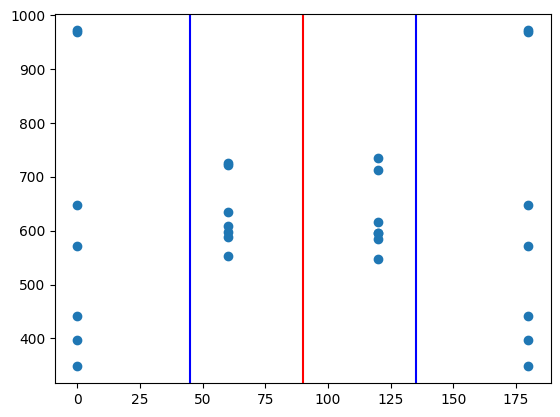

In [42]:
n_response = []

for k in k_collection:
    n_response.append(np.sum(img*k))
print(f"len(n_response) ={len(n_response)}")
plt.figure()
plt.scatter(np.array(param_collection['theta'])*180/np.pi, np.abs(n_response))
plt.axvline(x = 45, color = 'b')
plt.axvline(x = 90, color = 'r')
plt.axvline(x = 135, color = 'b')